In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
!pip install patchify

In [4]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 22.5 MB/s eta 0:00:00


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import time
import os
from patchify import patchify, unpatchify
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, random_split
import timm
import lightning as L

In [6]:
transform = transforms.Compose([transforms.Resize(384),
                                transforms.ToTensor()
                                ])

In [7]:
batch_size = 8
fake_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Manipulated/DeepFake'
real_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Original/Original'

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = [os.path.join(path, f) for f in os.listdir(path)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        image = Image.open(file)
        label = 0.0 if "Original" in file else 1.0
        if self.transform:
            image = self.transform(image)
        return image, label

custom_fake_dataset = CustomImageDataset(fake_dir, transform=transform)

total_samples = len(custom_fake_dataset)
train_size = 2938 #int(0.7 * total_samples)
val_size = 200 #int(0.2 * total_samples)
test_size = 100 #total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

fake_train_subset, fake_val_subset, fake_test_subset, _ = random_split(
    custom_fake_dataset, [train_size, val_size, test_size, rem_size]
)

custom_real_dataset = CustomImageDataset(real_dir, transform=transform)

total_samples = len(custom_real_dataset)
train_size = 2938 # int(0.7 * total_samples)
val_size = 200 # int(0.2 * total_samples)
test_size = 100 # total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

real_train_subset, real_val_subset, real_test_subset, _ = random_split(
    custom_real_dataset, [train_size, val_size, test_size, rem_size]
)

train_dataset = torch.utils.data.ConcatDataset([fake_train_subset, real_train_subset])
val_dataset = torch.utils.data.ConcatDataset([fake_val_subset, real_val_subset])
test_dataset = torch.utils.data.ConcatDataset([fake_test_subset, real_test_subset])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=False)

In [8]:
print("Train Loader Length", len(train_dataset))
print("Validation Loader Length", len(val_dataset))
print("Test Loader Length", len(test_dataset))

Train Loader Length 5876
Validation Loader Length 400
Test Loader Length 200


Feature batch shape: torch.Size([8, 3, 384, 384])
Labels batch shape: torch.Size([8])


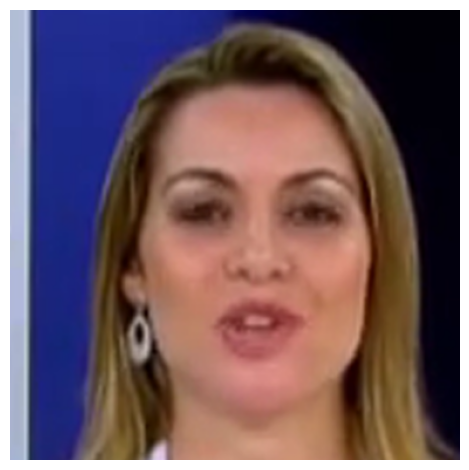

Label: 0.0


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Label: {label}")

In [10]:
class Xception(nn.Module):
  def __init__(self):
        super(Xception, self).__init__()
        # self.xception_model = tf.keras.applications.xception.Xception(
        #     include_top=False,
        #     weights='imagenet',
        #     input_shape = (384, 384, 3)
        # )
        # self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.global_avg_pool = nn.AvgPool2d(12, 12)
        self.xception_model = timm.create_model('xception', pretrained=True)

  def forward(self, input):
        # x = input.permute(0, 2, 3, 1)
        # x = tf.keras.applications.xception.preprocess_input(x)
        # output = self.xception_model(x.numpy())
        # output = self.global_avg_pool(output.numpy())
        # return output.numpy()
        output = self.xception_model.forward_features(input)
        output = self.global_avg_pool(output)
        return output

In [11]:
class PatchModule(nn.Module):
  def __init__(self):
    super(PatchModule, self).__init__()
    self.conv = nn.ModuleList([
            nn.ModuleList([
                nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
                for j in range(24)
            ])
            for i in range(24)
        ])

  def extract_patches(self, img):
    patch_size = 16
    stride = 16
    patches = img.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    patches = patches.permute(2, 3, 0, 1, 4, 5).squeeze(axis=0)
    return patches

  def forward(self, x):
    patches = self.extract_patches(x)
    conv_patches = torch.zeros(24, 24, x.size(0), 3, 16, 16, device=x.device)
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        for batch_idx in range(patches.shape[2]):
          conv_patches[i][j][batch_idx] = self.conv[i][j](patches[i][j][batch_idx])
    patches = patches / (torch.max(patches) + 1e-6)
    conv_patches = conv_patches / (torch.max(conv_patches) + 1e-6)
    output_image = patches * conv_patches
    output_image = output_image / (torch.max(output_image) + 1e-6)
    return output_image

In [12]:
pm = PatchModule()
outp = pm(train_features)

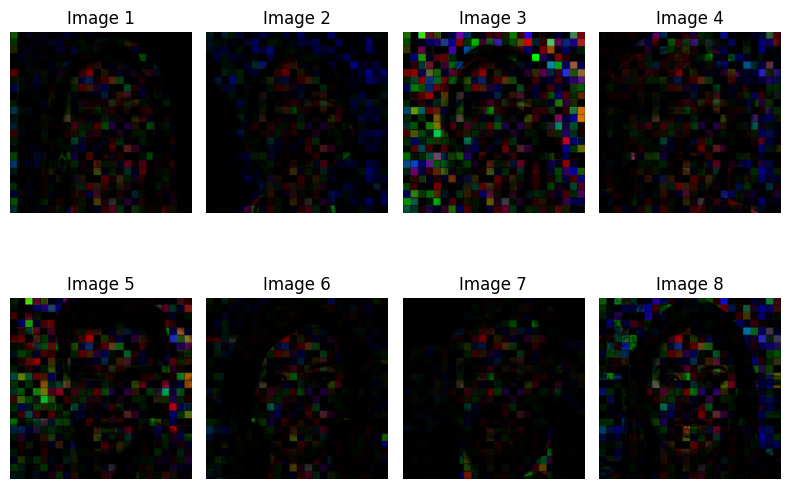

In [13]:
# Display the Self Attention Patched Images
# Permute the tensor to bring batch and channel to the front
tensor = outp.permute(2, 3, 0, 4, 1, 5)  # [batch, channel, patch_dim1, height, patch_dim2, width]

# Reshape to combine patches into full images
batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
combined_images = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)

# Display the images
def show_images(images, custom_width=2, custom_height=2):
    batch_size, channels, height, width = images.shape
    rows, cols = 2, 4  # Two rows, four columns
    fig, axes = plt.subplots(rows, cols, figsize=(8, 6))  # Set custom figure size

    for i in range(rows):
        for j in range(cols):
            img = images[i * cols + j].permute(1, 2, 0).detach().numpy()  # [C, H, W] to [H, W, C]
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Image {i * cols + j + 1}")
            axes[i, j].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Show the combined images
show_images(combined_images)


In [14]:
class VIT_Encoder(nn.Module):
  def __init__(self):
    super(VIT_Encoder, self).__init__()
    self.vit_model = timm.create_model('vit_small_patch16_384.augreg_in1k', pretrained=True)

  def forward(self, x):
    output = self.vit_model.forward_features(x)
    return output

In [15]:
class Classification_Module(nn.Module):
  def __init__(self):
    super(Classification_Module, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(223616, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Softmax()
    )

  def forward(self, input):
    return self.model(input)

In [16]:
class ViXNet(nn.Module):
    def __init__(self):
      super(ViXNet, self).__init__()
      self.patch_module = PatchModule()
      self.vit_encoder = VIT_Encoder()
      self.xception = Xception()
      self.classification = Classification_Module()

    def combine_patches(self, patches):
      tensor = patches.permute(2, 3, 0, 4, 1, 5)
      batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
      combined_images = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)
      return combined_images

    def forward(self, x):
      patch_module_output = self.combine_patches(self.patch_module(x))
      vit_output = torch.flatten(self.vit_encoder(patch_module_output), 1, 2)
      xception_output = torch.flatten(self.xception(x), 1, 3)
      output = torch.cat((
          vit_output,
          xception_output
          ), dim=1)

      output = self.classification(output)
      return output

In [17]:
class LitViXNet(L.LightningModule):
    def __init__(self, vixnet):
        super().__init__()
        self.vixnet = vixnet

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = torch.unsqueeze(labels, 1)
        outputs = self.vixnet(images)
        loss =  nn.CrossEntropyLoss()(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [18]:
vixnet = ViXNet()
print(vixnet)
total_params = sum(p.numel() for p in vixnet.parameters())
print(f"Number of parameters: {total_params}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


ViXNet(
  (patch_module): PatchModule(
    (conv): ModuleList(
      (0-23): 24 x ModuleList(
        (0-23): 24 x Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (vit_encoder): VIT_Encoder(
    (vit_model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
       

In [19]:
model = LitViXNet(vixnet)

In [26]:
trainer = L.Trainer(limit_train_batches=2, max_epochs=2, devices=1)
trainer.fit(model=model, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params
----------------------------------
0 | vixnet | ViXNet | 159 M 
----------------------------------
159 M     Trainable params
0         Non-trainable params
159 M     Total params
639.029   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | vixnet | ViXNet | 159 M 
----------------------------------
159 M     Trainable params
0         Non-trainable params
159 M     Total params
639.029   Total estimat

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(
    train_acc, color='green', linestyle='-',
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-',
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/accuracytl.png')
plt.show()
# loss plots
plt.figure(figsize=(5, 5))
plt.plot(
    train_loss, color='orange', linestyle='-',
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-',
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/losstl.png')
plt.show()
# save the final model
save_path = 'model_res.pth'
torch.save(model.state_dict(), save_path)
print('MODEL SAVED...')